## Implementation of Neural network from scratch

In [375]:
del params

In [195]:
import numpy as np
from statistics import mean 
import pandas as pd
import numpy.random as r
from random import randrange
from tqdm import tqdm_notebook as tqdm
from matplotlib import pyplot as plt

In [2]:
def activation(x):
    return 1 / (1 + np.exp(-x))

def d_activation(x):
    return np.multiply(x,1-x)

def cost(yHat,y):
    return (y-yHat).dot(y-yHat)

In [3]:
def init_net(inputSize, num_hidden, outputSize, offset):
    input_size = inputSize
    output_size = outputSize
    params = {}
    params["inputSize"] = input_size
    params["outputSize"] = output_size
    params["n_layers"] = num_hidden+1
    for hl in range(0, num_hidden):
        params["layer_" + str(hl)] = r.rand(input_size, input_size)-offset
        params["biases_" + str(hl)] = r.rand(input_size)+offset
    params["layer_"+ str(hl + 1)] = r.rand(output_size, input_size)-offset
    params["biases_" + str(hl+1)] = r.rand(output_size)+offset
    return params

In [4]:
def forwardPass(x,y,params):
    params = params
    x = x[np.newaxis].T
    for layer in range(0, params["n_layers"]):
        w = params["layer_" + str(layer)]
        if layer == 0:
            z = np.matmul(w,x)+(params["biases_"+str(layer)][np.newaxis].T)
            a = activation(z)
            params["a_layer" + str(layer)] = a
            params["a_prev" + str(layer)] = x
            params["d_transfer_layer" + str(layer)] = np.multiply(a,(1-a))
        else:
            node_in = a
            z = np.matmul(w,node_in)+(params["biases_"+ str(layer)][np.newaxis].T)
            a = activation(z)
            params["a_layer" + str(layer)] = a
            params["a_prev" + str(layer)] = node_in
            params["d_transfer_layer" + str(layer)] = np.multiply(a,(1-a))
    final_error = np.subtract(y,a)
    #params["final_error"] = np.asarray(final_error/params["outputSize"])
    params["final_error"] = (1/params["outputSize"])*(np.squeeze(y)-np.squeeze(a))
    return params

## Backpropogation

### 1. error propogation

In [350]:
def errorPropogate(params):
    error = params['final_error']
    params['error_layer'+str(params["n_layers"]-1)] = error[np.newaxis].T
    
    for i in range(params["n_layers"]-1,0,-1):
        k = i-1
        error_prev = params['error_layer'+str(k+1)]
        w_prev = params['layer_'+str(k+1)]
        error = np.matmul(w_prev.T, error_prev.ravel())
        params['error_layer'+str(k)] = error[np.newaxis].T
    return params

### 2. backprop

In [351]:
def backprop(params, update=True):
    params = errorPropogate(params)
    delta = 1
    error_slopes = {}
    for i in range(params["n_layers"],0,-1):
        k = i-1
        e = np.squeeze(params['error_layer'+str(k)]).reshape(-1,1)
        sigma_dash = params["d_transfer_layer" + str(k)]
        delta = np.multiply(e,sigma_dash)
        del_w = np.matmul(delta,params["a_prev" + str(k)].T)
        error_slopes["del_w_" + str(k)] = del_w
        error_slopes["delta_" + str(k)] = delta
        if update:
            params["layer_" + str(k)] += params["learningRate"]*del_w
            params["biases_" + str(k)] += params["learningRate"]*np.squeeze(delta)
    params["deltas"] = error_slopes
    return params

## Training Schemes
### 1. Batch training

In [360]:
def batch_train_neuralnet(x,y,lr,params,batchSize):
    params["learningRate"] = lr
    m = len(y)
    tmp = []
    result = {}
    batch = np.random.choice(m, batchSize, replace=False)
    
    for item in batch:
        
        params = forwardPass(x[item], y[item], params)
        params = backprop(params, update = False)
        dict_in = params["deltas"]
        result = {key: (result.get(key, 0) + dict_in.get(key, 0))/batchSize
              for key in set(result) | set(dict_in)}
    params["deltas"] = result  
        
    for i in range(params["n_layers"],0,-1):
        k = i-1
        params["layer_" + str(k)] += params["learningRate"]*params["deltas"]["del_w_"+str(k)]
        params["biases_" + str(k)] += params["learningRate"]*np.squeeze(params["deltas"]["delta_"+str(k)])

    return params


### 2. Online training

In [341]:
def online_train_neuralnet(x,y,inSize,n_hidden,outSize,lr,epochs):
    params = init_net(inSize,n_hidden,outSize, 0.9)
    params["learningRate"] = lr
    epoch_error = []
    m = len(y)
    for epoch in tqdm(range(0,epochs)):
        j = randrange(0,m)
        params = forwardPass(x[j], y[j], params)
        params = backprop(params, update = True)
        s = np.array(params["final_error"])
        e = s.dot(s)
        epoch_error.append(e)
    return params, epoch_error


## Sample dataset 

In [352]:
dataset = pd.DataFrame([[2.7810836, 2.550537003, 0],
           [1.465489372, 2.362125076, 0],
           [3.396561688, 4.400293529, 0],
           [1.38807019, 1.850220317, 0],
           [3.06407232, 3.005305973, 0],
           [7.627531214, 2.759262235, 1],
           [5.332441248, 2.088626775, 1],
           [6.922596716, 1.77106367, 1],
           [8.675418651, -0.242068655, 1],
           [7.673756466, 3.508563011, 1]])

i = dataset.values[:,0:2]
o = dataset.values[:,2]

### Online training

In [353]:
result = online_train_neuralnet(i,o,2,3,1,0.05,20000)

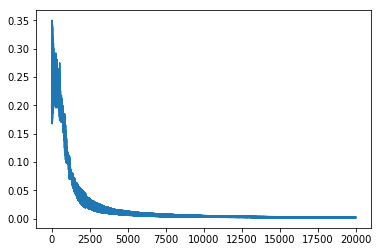

In [354]:
plt.plot(result[1])
plt.show()

### Batch training

In [361]:
epoch_error = []
epochs = 10000
params = init_net(2,3,1, 0.9)
batch_error = []

for epoch in range(0,epochs):
    params = batch_train_neuralnet(i,o,0.09,params,2)
    j = randrange(0,9)
    p = forwardPass(i[j], o[j], params)
    s = np.array(p["final_error"])
    e = s.dot(s)
    print("error---",e)
    batch_error.append(e)
    del p,s,e

error--- 0.08323974479353195
error--- 0.0845390841158371
error--- 0.5024042288752248
error--- 0.08487150838165014
error--- 0.08605497152223597
error--- 0.08660768006755067
error--- 0.08551725325634069
error--- 0.08446203886001648
error--- 0.08318154909465579
error--- 0.508205013123373
error--- 0.5078031875465016
error--- 0.5070984563568063
error--- 0.08499468440054284
error--- 0.503478949994229
error--- 0.49796367993538987
error--- 0.49785183050891163
error--- 0.4972798477641541
error--- 0.4936483001900878
error--- 0.4930067288032245
error--- 0.08866762823845102
error--- 0.08967825146758235
error--- 0.49275864618968285
error--- 0.4861317874006302
error--- 0.4858567911519487
error--- 0.09144066882068398
error--- 0.48593945967584357
error--- 0.4856583808257005
error--- 0.485385389200848
error--- 0.4885067523371692
error--- 0.48986756723429764
error--- 0.48430656554564366
error--- 0.4786692185135949
error--- 0.09368563654624129
error--- 0.47447555884680076
error--- 0.0953453561888439
erro

error--- 0.2935903696105406
error--- 0.20270925105016735
error--- 0.20221919335417807
error--- 0.29490999537440915
error--- 0.29978121837877036
error--- 0.19650372933253588
error--- 0.2011930940946378
error--- 0.2059472851777668
error--- 0.29275920984216697
error--- 0.20960622250435912
error--- 0.21604967729545616
error--- 0.21175022630289161
error--- 0.2852264454143415
error--- 0.2169075674393217
error--- 0.2771030549951391
error--- 0.2222954170294466
error--- 0.28029245452046286
error--- 0.21657237641834723
error--- 0.21602045388860694
error--- 0.2207950338289454
error--- 0.2235463261881214
error--- 0.22519976130204006
error--- 0.27483705583696105
error--- 0.2694602148586689
error--- 0.2744500112159251
error--- 0.2780478642959682
error--- 0.2723791636701109
error--- 0.27508318870004844
error--- 0.27300672734697723
error--- 0.220157115177379
error--- 0.26772255516003984
error--- 0.26593609256785555
error--- 0.22932764889214222
error--- 0.265466660764108
error--- 0.26693220697143194
er

error--- 0.2142022056838556
error--- 0.25294609342207597
error--- 0.21733502949951292
error--- 0.21587746175491657
error--- 0.21726896318316927
error--- 0.22090931945603282
error--- 0.2199544850926436
error--- 0.24851094989751896
error--- 0.22006321797236297
error--- 0.21559671949301987
error--- 0.21113884259171517
error--- 0.26197478753877695
error--- 0.2119769040630326
error--- 0.21268995116341696
error--- 0.24502965561317797
error--- 0.21338513366358616
error--- 0.21195267249362504
error--- 0.20707619779225528
error--- 0.2085507319102075
error--- 0.2050326134176164
error--- 0.25893078021971777
error--- 0.26054183965867056
error--- 0.2645296868638179
error--- 0.26189282460404173
error--- 0.2000819200441506
error--- 0.201540305498641
error--- 0.2663722627389732
error--- 0.20421441949206895
error--- 0.20134747043834808
error--- 0.19714658160854487
error--- 0.19891537925681285
error--- 0.2565846943731655
error--- 0.25405813946850686
error--- 0.2537992877341957
error--- 0.244946048513226

error--- 0.19352356791184522
error--- 0.14180912650974115
error--- 0.14137151585190041
error--- 0.14191066939380717
error--- 0.14289387132637196
error--- 0.14544767909642672
error--- 0.14369566462269776
error--- 0.14331477147483562
error--- 0.14656785481396678
error--- 0.14374989655534318
error--- 0.18911340955547776
error--- 0.1902032518074243
error--- 0.14360945517717194
error--- 0.14442970678378625
error--- 0.18720638303028006
error--- 0.18737229821985907
error--- 0.1862469810081292
error--- 0.18668972672701967
error--- 0.18504440556275237
error--- 0.18198314682046307
error--- 0.1845261471388615
error--- 0.13951961778529046
error--- 0.13679549955773432
error--- 0.1341047830911952
error--- 0.131617488772919
error--- 0.1341307513517918
error--- 0.13830742783392638
error--- 0.18560282158236827
error--- 0.13738810663233547
error--- 0.18106152119393942
error--- 0.1410292228601314
error--- 0.13665377726887704
error--- 0.1408629168632397
error--- 0.14109668407925563
error--- 0.140519017343

error--- 0.06834568707459981
error--- 0.0995100949004325
error--- 0.0993906618044189
error--- 0.06757622041481484
error--- 0.06681442368588437
error--- 0.06668104226338308
error--- 0.1007912836993421
error--- 0.06473085369312885
error--- 0.06605966560762835
error--- 0.1001818479253494
error--- 0.10073041166863773
error--- 0.06538147771837907
error--- 0.06556447588015776
error--- 0.06525832091256932
error--- 0.06437088831252785
error--- 0.0987538114837979
error--- 0.06336495869261921
error--- 0.10027852916872763
error--- 0.09858103292185404
error--- 0.06386083123215082
error--- 0.06346952029762214
error--- 0.06253726170478613
error--- 0.09913598715628825
error--- 0.09924404302985261
error--- 0.061423089213733253
error--- 0.06102175450070117
error--- 0.0996014997557822
error--- 0.06149502071357026
error--- 0.060518546737188664
error--- 0.09826744273149356
error--- 0.0616420244047028
error--- 0.09687192216711656
error--- 0.0970065512446855
error--- 0.06233392460613206
error--- 0.063008717

error--- 0.058441401030629704
error--- 0.03598472628380095
error--- 0.058338940395315106
error--- 0.035798210247125435
error--- 0.03606402394356618
error--- 0.05774778021781965
error--- 0.05772918618470167
error--- 0.057580859814507376
error--- 0.03634276537922282
error--- 0.03608875884898165
error--- 0.03565209905281698
error--- 0.035525929022246314
error--- 0.0360096998645171
error--- 0.035986109142941494
error--- 0.036069020652930744
error--- 0.05680379032002789
error--- 0.05705590107429078
error--- 0.03597531288969665
error--- 0.05676559068485544
error--- 0.056818293012495656
error--- 0.03581067972775384
error--- 0.03584703532258937
error--- 0.05648463059092396
error--- 0.056052476103899046
error--- 0.03622043376636467
error--- 0.035877375951048694
error--- 0.03581853767219612
error--- 0.035891685291367895
error--- 0.03550950192517911
error--- 0.056274326705618036
error--- 0.035420822158851895
error--- 0.0355690589518854
error--- 0.03543969325354706
error--- 0.035237962046046886
er

error--- 0.024720230843584746
error--- 0.04285871574975829
error--- 0.042602529162980594
error--- 0.02478986791058058
error--- 0.02480999939680134
error--- 0.024841299099602778
error--- 0.02497542680103222
error--- 0.024992329312033903
error--- 0.04196944982130914
error--- 0.02472814857201714
error--- 0.024731333003895763
error--- 0.024864484042475814
error--- 0.02497984814737143
error--- 0.025130918746173726
error--- 0.025125328803198614
error--- 0.02514566070833774
error--- 0.041300436972179944
error--- 0.041111713163729795
error--- 0.02508977623635824
error--- 0.025105121407655685
error--- 0.024917021742568924
error--- 0.024729723188843658
error--- 0.04149577364007883
error--- 0.024413389832904094
error--- 0.041503924574812986
error--- 0.02421511287385863
error--- 0.04137525894640294
error--- 0.024475976655528222
error--- 0.02438427170495783
error--- 0.04108861024353593
error--- 0.04111242571571178
error--- 0.0409615755406422
error--- 0.02438738220308697
error--- 0.02416856158299947

error--- 0.016492965845643397
error--- 0.01645064985852665
error--- 0.016479519251499455
error--- 0.016550322260472764
error--- 0.03244956063498225
error--- 0.016466065337023234
error--- 0.03246568671066573
error--- 0.016494147708495974
error--- 0.032287223255905446
error--- 0.03231676966327301
error--- 0.016429679079859403
error--- 0.016380027744846103
error--- 0.016450793863956606
error--- 0.01641481444556569
error--- 0.016317097872090132
error--- 0.016281492760176267
error--- 0.01617946522429252
error--- 0.016077134914319287
error--- 0.03230048907514072
error--- 0.01608853731274745
error--- 0.03237891635230237
error--- 0.01597871343106608
error--- 0.03228730724042266
error--- 0.016149011769550404
error--- 0.03215041118582899
error--- 0.015974316473462983
error--- 0.01598843383186047
error--- 0.0160941982519655
error--- 0.015969348263794182
error--- 0.015869737491934117
error--- 0.032255738988425486
error--- 0.032325790822758924
error--- 0.01565973598757612
error--- 0.015618019890828

error--- 0.02640244091633995
error--- 0.01356497201028865
error--- 0.026325382965970073
error--- 0.013640737795348235
error--- 0.013582083346823207
error--- 0.013556634794175371
error--- 0.026271610427351415
error--- 0.02632171957333427
error--- 0.013424194294877689
error--- 0.013459808441345363
error--- 0.013407825319735087
error--- 0.013478742212089705
error--- 0.026205098326508164
error--- 0.026178239591757503
error--- 0.02609683217059792
error--- 0.02604821153235903
error--- 0.013493702972953086
error--- 0.0259303862786578
error--- 0.02589339925049778
error--- 0.025867848319527906
error--- 0.013604765675518233
error--- 0.013562078653482326
error--- 0.01359068505018983
error--- 0.02575266646749068
error--- 0.013520637091364127
error--- 0.025807047653488725
error--- 0.013460363092678364
error--- 0.02578834561211611
error--- 0.025824034076347792
error--- 0.01343409577772182
error--- 0.013455851894212483
error--- 0.02558783541669568
error--- 0.013552654199717714
error--- 0.025485120877

error--- 0.010267460113979016
error--- 0.010228381942804038
error--- 0.021915645859718894
error--- 0.010241803038120572
error--- 0.010222910180201617
error--- 0.021860701023509385
error--- 0.010234194515283216
error--- 0.010206796171857392
error--- 0.02187358325228846
error--- 0.021867760217249274
error--- 0.021869413102379907
error--- 0.010162838701920997
error--- 0.010109793644038896
error--- 0.021844271968975836
error--- 0.010099673918450573
error--- 0.010129644291169748
error--- 0.010112958934007628
error--- 0.010132303058373506
error--- 0.021733097352771198
error--- 0.02167549872974025
error--- 0.010185993341614213
error--- 0.010149409609247406
error--- 0.0101310165450306
error--- 0.02163125827870838
error--- 0.021603344222608286
error--- 0.021627249641502783
error--- 0.021607126996488927
error--- 0.021542677587898067
error--- 0.021493318302409373
error--- 0.021524515988669557
error--- 0.02151901512869185
error--- 0.010144383596357774
error--- 0.010148915084653884
error--- 0.02143

error--- 0.018812653555369162
error--- 0.00858473521312917
error--- 0.01876970891240643
error--- 0.01879300077381098
error--- 0.00855548440734875
error--- 0.018772337168659236
error--- 0.018728691950172842
error--- 0.008564298345013389
error--- 0.008585230876481026
error--- 0.018687105382960673
error--- 0.018688069481583046
error--- 0.018644834921051668
error--- 0.008586306007734293
error--- 0.008599758025168882
error--- 0.018603788398465118
error--- 0.01860481244519208
error--- 0.008572992484437101
error--- 0.008577818849883765
error--- 0.008599631833320026
error--- 0.008620025341427162
error--- 0.008641972326090172
error--- 0.0184848056702843
error--- 0.00863676929151482
error--- 0.008604672912328762
error--- 0.008635701661039673
error--- 0.01844571534801631
error--- 0.008604261535653706
error--- 0.018421915478299886
error--- 0.008595450272501389
error--- 0.00862460542097166
error--- 0.018317739474339362
error--- 0.01832348991273305
error--- 0.018277470401754415
error--- 0.0086340319

error--- 0.007889611924296385
error--- 0.007892661115987411
error--- 0.00789680853525578
error--- 0.007878018493131243
error--- 0.01565693450484078
error--- 0.007849234740289956
error--- 0.007866141332386459
error--- 0.007885104156439128
error--- 0.007899968076400362
error--- 0.007902938847814983
error--- 0.015551353593867038
error--- 0.00789601880920554
error--- 0.01555463244604121
error--- 0.007887038207038378
error--- 0.007903891314263537
error--- 0.007914025446434604
error--- 0.015481718234328564
error--- 0.015470091662053483
error--- 0.015469279165401091
error--- 0.015486766978012507
error--- 0.015488401745876712
error--- 0.007868745020894675
error--- 0.007885384327193996
error--- 0.015414438588084329
error--- 0.007926363831298003
error--- 0.00792908193678988
error--- 0.015388237179101415
error--- 0.015358638173441143
error--- 0.007930198016531111
error--- 0.007905054614189963
error--- 0.007881268480687573
error--- 0.007884080711899312
error--- 0.01532052066642359
error--- 0.01534

error--- 0.013291431082343496
error--- 0.013269037311855563
error--- 0.0066175447146292225
error--- 0.0066254338786752185
error--- 0.006607676267422832
error--- 0.00662047165390203
error--- 0.00663640574783248
error--- 0.006618567049282422
error--- 0.0066262835476521295
error--- 0.013195756054149495
error--- 0.006640576960215552
error--- 0.006657141118965695
error--- 0.00666599319904206
error--- 0.013153872345841332
error--- 0.006653381950585427
error--- 0.013144543430133765
error--- 0.01315895277176057
error--- 0.006616635218237093
error--- 0.013159236333752078
error--- 0.0065999460854191255
error--- 0.006592222182549291
error--- 0.006598682851356046
error--- 0.006577992137116664
error--- 0.013141343768067254
error--- 0.013119443051126032
error--- 0.01312048554135261
error--- 0.006575488591659351
error--- 0.01312252400503471
error--- 0.006579743338060249
error--- 0.0065830720435723035
error--- 0.0065643839268120395
error--- 0.01310374302614101
error--- 0.006550251135540972
error--- 0.

error--- 0.0059919185476173115
error--- 0.011990818671806248
error--- 0.005973366654834671
error--- 0.005955633746013038
error--- 0.012021946986035164
error--- 0.012022686934051676
error--- 0.00592919008401888
error--- 0.005930530787656071
error--- 0.005932382900405989
error--- 0.011987261690807697
error--- 0.011968903834937731
error--- 0.011960130340442708
error--- 0.0059394739694845315
error--- 0.005925637298396991
error--- 0.011971935877345137
error--- 0.0059207074051092785
error--- 0.005917691140614158
error--- 0.005924787667680621
error--- 0.011965350157564548
error--- 0.005911846012806024
error--- 0.011938287633714847
error--- 0.01193904194267633
error--- 0.005901218680485357
error--- 0.005894998607188025
error--- 0.005897279532916963
error--- 0.005883522766786538
error--- 0.0058773893174501315
error--- 0.011952828904256196
error--- 0.005864797609375382
error--- 0.005874075736891763
error--- 0.011945414901090006
error--- 0.0058539302603825465
error--- 0.011929246420522044
error--

error--- 0.005326398885972574
error--- 0.005321689276184067
error--- 0.010911200271811099
error--- 0.005313726289608862
error--- 0.010920182508462103
error--- 0.0053012942672713715
error--- 0.010927978123589277
error--- 0.005298170274393211
error--- 0.0052863440364994746
error--- 0.005290258284483953
error--- 0.01092197478123646
error--- 0.010923584792993745
error--- 0.010914989890335928
error--- 0.005274948562764236
error--- 0.00526357601064455
error--- 0.010908484694056562
error--- 0.0109022021387388
error--- 0.010893625531250263
error--- 0.005256508397265741
error--- 0.005245776349641584
error--- 0.005233932091187879
error--- 0.010919095975169095
error--- 0.01091162398383477
error--- 0.005226409343647357
error--- 0.010912473365848425
error--- 0.005223162175209711
error--- 0.010906596438498466
error--- 0.010897963822607663
error--- 0.005216793520633098
error--- 0.010883079290076017
error--- 0.010868975002438438
error--- 0.010868265161030923
error--- 0.005221005332288105
error--- 0.00

error--- 0.004734711306690389
error--- 0.004725517950187879
error--- 0.010122576141440708
error--- 0.004718131708120551
error--- 0.004719068691894589
error--- 0.0047261636547630366
error--- 0.004732619501146209
error--- 0.004735493534901622
error--- 0.004731560527630017
error--- 0.010090534766318287
error--- 0.004721973784037993
error--- 0.01007758207684346
error--- 0.010084543479467405
error--- 0.004710508040476092
error--- 0.010085016544966702
error--- 0.004709489902738429
error--- 0.01008641644369804
error--- 0.010078994892193315
error--- 0.010073427015454486
error--- 0.004708407580115844
error--- 0.004709768769989543
error--- 0.010046488875915834
error--- 0.004701526536562741
error--- 0.004694259193249983
error--- 0.004683648174036131
error--- 0.010061637032970734
error--- 0.01006853688987394
error--- 0.010055388535536985
error--- 0.004678911118953293
error--- 0.010055822492258002
error--- 0.010061831297148795
error--- 0.010068707036170663
error--- 0.0046495292701632905
error--- 0.

error--- 0.004406284529074256
error--- 0.009046980527344598
error--- 0.009046632858368712
error--- 0.004409007411678817
error--- 0.004414574285260638
error--- 0.004415578950846627
error--- 0.004421346816927645
error--- 0.009010642472916908
error--- 0.009004891361059574
error--- 0.009010691550471302
error--- 0.004411813010937288
error--- 0.004403596337712371
error--- 0.0044004763487959985
error--- 0.009018128658648214
error--- 0.009017803810861563
error--- 0.00438968261066257
error--- 0.004390722421676538
error--- 0.004387626520335216
error--- 0.009008190560065427
error--- 0.009013948427825874
error--- 0.004367979510763522
error--- 0.009009756223649043
error--- 0.008998553159455696
error--- 0.004379982723524754
error--- 0.008999843207269478
error--- 0.004373102007471103
error--- 0.00436967063563558
error--- 0.004362174511638203
error--- 0.008990219315405735
error--- 0.008979700905614351
error--- 0.00898542895079598
error--- 0.004358503181653851
error--- 0.004358057493428852
error--- 0.0

error--- 0.008425497091186143
error--- 0.004001311985444767
error--- 0.00400690764984558
error--- 0.004011617313566623
error--- 0.008407350996620398
error--- 0.004004832010856913
error--- 0.008403033349679312
error--- 0.0040068197036592455
error--- 0.004001057819849783
error--- 0.003997175695508211
error--- 0.00839439808056638
error--- 0.008394599233537595
error--- 0.003997203240099172
error--- 0.008399705298288056
error--- 0.00839112685826506
error--- 0.008390675139953712
error--- 0.008386169506654896
error--- 0.00399051276212181
error--- 0.008382501879932317
error--- 0.003988574033849313
error--- 0.008373506843836045
error--- 0.008377758613154927
error--- 0.003979290230919207
error--- 0.008387522967405728
error--- 0.008383012885299537
error--- 0.0039780573903364985
error--- 0.008369971341745292
error--- 0.003983868769154288
error--- 0.008360363930103839
error--- 0.003985440748574665
error--- 0.003990227087894079
error--- 0.0083382784626881
error--- 0.008343150804464818
error--- 0.003

error--- 0.0038355058689549075
error--- 0.0038360089361797055
error--- 0.003833462215240856
error--- 0.0038342001167950353
error--- 0.003835037591795219
error--- 0.007757200793297439
error--- 0.003829684885367057
error--- 0.007754117894561866
error--- 0.007757974312747353
error--- 0.007758227943379792
error--- 0.007754409869276881
error--- 0.007754659549206263
error--- 0.007754908520245657
error--- 0.0038142549123660195
error--- 0.0038116114964638352
error--- 0.0077556525669530176
error--- 0.003806477789254086
error--- 0.003810462178441356
error--- 0.003808052534289214
error--- 0.0038020460221536738
error--- 0.003802790189565465
error--- 0.007736834322463512
error--- 0.0038040460947109584
error--- 0.0037989950273092737
error--- 0.0077461636006462145
error--- 0.0037961927366322026
error--- 0.007738043914722962
error--- 0.007734736098276233
error--- 0.007730934722498242
error--- 0.007730677130786624
error--- 0.007730916855438136
error--- 0.0037907920882762646
error--- 0.00772381909782712

error--- 0.0035806365902483926
error--- 0.0035840742207039577
error--- 0.007245468659556092
error--- 0.003577223215988735
error--- 0.007238791186114788
error--- 0.007235460221245198
error--- 0.007228962012767459
error--- 0.003581932768391448
error--- 0.007229037090695598
error--- 0.0035803402688084976
error--- 0.007225941234918005
error--- 0.007229710696828899
error--- 0.007229932337718552
error--- 0.007234090665323552
error--- 0.007230761766187705
error--- 0.00356339753289813
error--- 0.007234339012685278
error--- 0.0035565018247978356
error--- 0.0035504727400049595
error--- 0.003548181463913524
error--- 0.007242252417658909
error--- 0.007235357088682919
error--- 0.003550930661054563
error--- 0.003550885558152989
error--- 0.003551424587726626
error--- 0.0072184895475704445
error--- 0.007218698564032821
error--- 0.0072224372934373456
error--- 0.0035423632555323437
error--- 0.0035378559997853247
error--- 0.0072230393795997315
error--- 0.0035326141167785334
error--- 0.0035333421855894627

error--- 0.0033676630287130804
error--- 0.003368270073928132
error--- 0.00336409797701278
error--- 0.0033640302128421728
error--- 0.006722843114757053
error--- 0.006716890493995893
error--- 0.0033603159419725377
error--- 0.006714540322113231
error--- 0.003359466349460005
error--- 0.006711580579551626
error--- 0.006711792493760232
error--- 0.006706161923094783
error--- 0.0033583910005453035
error--- 0.006709663797573549
error--- 0.0033542436318698804
error--- 0.006703633928328709
error--- 0.006700778502935193
error--- 0.006701299428061805
error--- 0.006698137876306563
error--- 0.0033543740943957853
error--- 0.0066924394813362735
error--- 0.00335857437575516
error--- 0.0033564978492929857
error--- 0.0033563369370061416
error--- 0.006690549262960959
error--- 0.0033522848696112733
error--- 0.0033501231067871776
error--- 0.006687816840895724
error--- 0.003351192706170093
error--- 0.0033465238736387465
error--- 0.0033420344709009417
error--- 0.006682552414647973
error--- 0.006679713738020183

error--- 0.0063214800864187775
error--- 0.006318929891851331
error--- 0.0031572513966866647
error--- 0.006316562151533786
error--- 0.006319736554223279
error--- 0.0063169163000787905
error--- 0.003147696139734565
error--- 0.0063172665092139455
error--- 0.003151451033833321
error--- 0.006306733749437472
error--- 0.0031495259572212665
error--- 0.006307358853232209
error--- 0.003145948545461986
error--- 0.006310159899978314
error--- 0.006310332664775943
error--- 0.0031450042031938063
error--- 0.006307962503416447
error--- 0.003136789054980364
error--- 0.0031327750873622246
error--- 0.006316619410985513
error--- 0.00631160748038085
error--- 0.0031301564394135726
error--- 0.006308964173560749
error--- 0.006309129508909018
error--- 0.003131097404732608
error--- 0.006301328683561858
error--- 0.003127497474090878
error--- 0.0031303098324941742
error--- 0.003133010031522511
error--- 0.006296841841587216
error--- 0.003127051387892156
error--- 0.003122988691052279
error--- 0.0031189272988624045
e

error--- 0.005992173208514846
error--- 0.002971997175188424
error--- 0.0029704362854172488
error--- 0.005992609691609225
error--- 0.0029691845986105432
error--- 0.002969612422053885
error--- 0.0029726066785790125
error--- 0.005980960920314009
error--- 0.0029730228696577318
error--- 0.0029713292213143314
error--- 0.0029697711640064937
error--- 0.005971796400718381
error--- 0.0029746714169865737
error--- 0.005962363032482623
error--- 0.005964949258715596
error--- 0.005965101823529663
error--- 0.005965253087985036
error--- 0.002966644791395919
error--- 0.002962870623118093
error--- 0.005968350865281639
error--- 0.0029617460420160746
error--- 0.0029626003315363853
error--- 0.0029630281891101125
error--- 0.0059616507402524
error--- 0.005961571261756394
error--- 0.005961717491241592
error--- 0.0029622064696261906
error--- 0.002964673445626954
error--- 0.0029650970013147967
error--- 0.005947776527494148
error--- 0.002963895381169384
error--- 0.0059456608576996944
error--- 0.005943396494561406

error--- 0.0027820885043648128
error--- 0.0027803370888621766
error--- 0.005626964278903678
error--- 0.005629249932976021
error--- 0.0027815188124831903
error--- 0.0056227859105627935
error--- 0.005620748691854105
error--- 0.005620869857938731
error--- 0.0027793567301019895
error--- 0.0027780197192040887
error--- 0.0027769041058953547
error--- 0.0056213485355498674
error--- 0.002775567904095418
error--- 0.0027744481215190016
error--- 0.0027708613487508337
error--- 0.00276770883220889
error--- 0.002766252792440069
error--- 0.005624199612714272
error--- 0.005624311406615661
error--- 0.002760267271488839
error--- 0.005624754071134625
error--- 0.00562248634876315
error--- 0.0027596457818876334
error--- 0.0027565487777573075
error--- 0.005624967279808158
error--- 0.002753769164067464
error--- 0.002752382339338236
error--- 0.005623352502313904
error--- 0.00562108431028959
error--- 0.005616890091871998
error--- 0.0056129221034873595
error--- 0.002754236771872601
error--- 0.0056150672606806295

error--- 0.0054067443987109425
error--- 0.002625174192046734
error--- 0.0026252483501637445
error--- 0.005403027901486497
error--- 0.005403112776443637
error--- 0.0026230964403181566
error--- 0.0053993154510868415
error--- 0.005401383381042589
error--- 0.0026209156795856704
error--- 0.00539956891709931
error--- 0.005395691303407615
error--- 0.0026187253295053793
error--- 0.005395859860878928
error--- 0.0026165836465212055
error--- 0.0026149809866454795
error--- 0.002612481924896946
error--- 0.0026096329411106635
error--- 0.005398243915293698
error--- 0.002608401058998585
error--- 0.002610371244195065
error--- 0.0026091776811228836
error--- 0.002606335516565383
error--- 0.002605055907211914
error--- 0.0026022981816974794
error--- 0.005400763630716404
error--- 0.0054008374819883775
error--- 0.005400910796541712
error--- 0.0025957169141061325
error--- 0.005401053483768874
error--- 0.0054032762332910595
error--- 0.005401194032306981
error--- 0.0054012642182055225
error--- 0.002592790649226

error--- 0.005189978453243535
error--- 0.005191858015590329
error--- 0.002473863966738297
error--- 0.0024727978451383734
error--- 0.002471692289510356
error--- 0.0024735167799527433
error--- 0.0024724089603513646
error--- 0.0024726860009990125
error--- 0.005188586099347885
error--- 0.002471961585617352
error--- 0.0051850513421055336
error--- 0.005185104536883188
error--- 0.0024700556118744522
error--- 0.005185210228637949
error--- 0.005181626177818972
error--- 0.005183496575264693
error--- 0.0051836960818349475
error--- 0.005181782609158819
error--- 0.005181984856087958
error--- 0.005178255373790528
error--- 0.005174680988277011
error--- 0.005174735214224026
error--- 0.0051747888797305155
error--- 0.005173181286604216
error--- 0.005175047478455921
error--- 0.005176759403591444
error--- 0.002461933682312959
error--- 0.0024593736601175474
error--- 0.002458308025692594
error--- 0.005178770591978514
error--- 0.005178818224317315
error--- 0.005178864553372965
error--- 0.00245249445945233
er

error--- 0.002356573923904351
error--- 0.002355546610981586
error--- 0.004959128757204026
error--- 0.004957508950617795
error--- 0.0023564569225698524
error--- 0.0023567716337717626
error--- 0.0023571453331585886
error--- 0.004951041991162197
error--- 0.002359091941576396
error--- 0.00236066546742936
error--- 0.004944551519680974
error--- 0.0049462565659599
error--- 0.002359018295654738
error--- 0.0023608655711636947
error--- 0.0023624977179865616
error--- 0.004936524311349435
error--- 0.0023628750642660746
error--- 0.004936626346840051
error--- 0.004936676540836933
error--- 0.004933424100549286
error--- 0.0023627559447594593
error--- 0.0023617759255658947
error--- 0.002360763423044828
error--- 0.004928684072094078
error--- 0.004925569991754542
error--- 0.0023603654817771495
error--- 0.004928968958909654
error--- 0.00235962638414684
error--- 0.0023615301203497694
error--- 0.004924058001284919
error--- 0.0023579466513091113
error--- 0.0023595373415615053
error--- 0.0023599015313325207
e

error--- 0.0022748014242788043
error--- 0.00227388517497175
error--- 0.0022729617195899323
error--- 0.0022722101366642665
error--- 0.004684700485140461
error--- 0.002271538938346956
error--- 0.004681826901879604
error--- 0.0022718898820792885
error--- 0.0022721097925107216
error--- 0.004680507878320514
error--- 0.0022726823967679504
error--- 0.002271760210311849
error--- 0.004677699772041713
error--- 0.004676377442785587
error--- 0.0022713054146645067
error--- 0.0022706111248642037
error--- 0.002269417248649587
error--- 0.002268475278670403
error--- 0.004672202068379117
error--- 0.004672151297942762
error--- 0.002270529647203915
error--- 0.0022707692667411185
error--- 0.004666385076549575
error--- 0.0022725184678678632
error--- 0.0022718210964327618
error--- 0.004662116945845912
error--- 0.004662178311787235
error--- 0.004662347373654203
error--- 0.004660926071199113
error--- 0.002268065064371326
error--- 0.004659457283933464
error--- 0.00466099854271356
error--- 0.002267908669084919
e

error--- 0.0044692228582852945
error--- 0.002191486187204965
error--- 0.004469242692796016
error--- 0.002193099128941758
error--- 0.0021922590436027306
error--- 0.0021935834228654044
error--- 0.0021927239074020087
error--- 0.0021907316046979736
error--- 0.0021888940685164913
error--- 0.0021867212392701466
error--- 0.002185824678821798
error--- 0.004465797514240214
error--- 0.002185378581076999
error--- 0.004468538827379128
error--- 0.002184529758491118
error--- 0.0021836808449282813
error--- 0.002185017043539754
error--- 0.004464785341992788
error--- 0.0021843832897302275
error--- 0.002182389408702071
error--- 0.004463495802901594
error--- 0.002182902429336568
error--- 0.004462251042872137
error--- 0.002181127354562699
error--- 0.0021802521265424967
error--- 0.0044624233214172184
error--- 0.004459761470797586
error--- 0.002177663654841668
error--- 0.002178996461672459
error--- 0.004459931898004432
error--- 0.002177254546034324
error--- 0.0021753150883979076
error--- 0.00217662683767160

error--- 0.00424987981101894
error--- 0.0021012882940054994
error--- 0.004244968330445282
error--- 0.00424379402229971
error--- 0.004245091344459056
error--- 0.004245152139029899
error--- 0.0021003010574465637
error--- 0.002099485968099867
error--- 0.004241628832577414
error--- 0.004239304045236458
error--- 0.0021032250702428105
error--- 0.0021032763457200098
error--- 0.0042370266575983235
error--- 0.0021026281047782217
error--- 0.0021038969038771013
error--- 0.0021032591859020074
error--- 0.002103289783994477
error--- 0.0021026524682932813
error--- 0.0021016522048295594
error--- 0.004231236255792531
error--- 0.002101021551575744
error--- 0.0021004106293004347
error--- 0.00423027753231886
error--- 0.0020996008085731373
error--- 0.0020987863994263883
error--- 0.0042291566891758834
error--- 0.0020981841230270806
error--- 0.0020986016852629166
error--- 0.002097581717773006
error--- 0.0020977941486273253
error--- 0.00209804886943005
error--- 0.0020994515976558033
error--- 0.002100691217259

error--- 0.002019686479375387
error--- 0.0020198521965428787
error--- 0.004095817040178694
error--- 0.0020193008636413792
error--- 0.00409715075982517
error--- 0.002017975205660905
error--- 0.0040961035810003705
error--- 0.004093780366257471
error--- 0.0020174854983321102
error--- 0.004093885610369518
error--- 0.0020178885002920693
error--- 0.0020171369384277666
error--- 0.004090599702399609
error--- 0.004091799555388285
error--- 0.002014849935397794
error--- 0.002016002531376088
error--- 0.0020171913660985796
error--- 0.0020164038903058424
error--- 0.0020175925097875172
error--- 0.002015889108696076
error--- 0.004084149078166286
error--- 0.004085346924329877
error--- 0.004086543935301145
error--- 0.004087819510961387
error--- 0.0020121075852737027
error--- 0.0020123088407056574
error--- 0.0020117358917628846
error--- 0.0020128855975595963
error--- 0.004084566145689464
error--- 0.004085760649830133
error--- 0.004086954555161802
error--- 0.0020078565308265612
error--- 0.0040859106538068

error--- 0.0019540412982189293
error--- 0.0019534680601299595
error--- 0.003887935809893181
error--- 0.0038880546612516955
error--- 0.001950298490789092
error--- 0.003888172528387751
error--- 0.001950629227976771
error--- 0.0019499219675421086
error--- 0.001948330080525295
error--- 0.0019494096225998888
error--- 0.0019487180205455428
error--- 0.0019471134984804528
error--- 0.0019455425223224763
error--- 0.0019467357977576078
error--- 0.0038855709574152596
error--- 0.003883488377094671
error--- 0.003881468387745209
error--- 0.0019492024811803086
error--- 0.0019501224294261963
error--- 0.0019511441335209202
error--- 0.0019522209096405883
error--- 0.0019506067656274138
error--- 0.0038735308133880392
error--- 0.0019518712286502897
error--- 0.0019528923790667488
error--- 0.003868542158537388
error--- 0.0019542941478953918
error--- 0.001954465603374934
error--- 0.0038646570473710915
error--- 0.0019546527350071045
error--- 0.0019532090887777855
error--- 0.0019540888467082795
error--- 0.003863

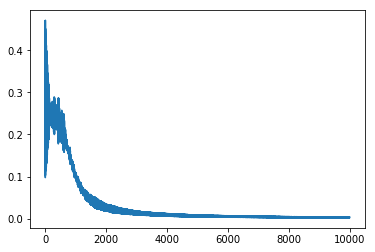

In [356]:
plt.plot(batch_error)
plt.show()